# Imports

In [2]:
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using AirBorne.ETL.AssetValuation: stockValuation
using AirBorne.Utils: rvcat, rblockdiag, δ
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, Order, place_order!, executeOrder_CA!
using AirBorne.Structures: summarizePerformance,TimeEvent, ContextTypeA

using Dates: DateTime,datetime2unix
using Statistics
using DirectSearch
using DotMaps
using Suppressor

using DataFrames: DataFrame, groupby, combine, mean
using DataFrames

using Dates
using DirectSearch
using PaddedViews


using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm, SparseVector 
using Ipopt: Ipopt
import MathOptInterface as MOI



# Get Data + Regressor

In [3]:
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
tickers = ["AAPL", "MSFT", "ISRG", "BABA", "SPY", "EFA", "TLT", "GLD"]
stocks = get_interday_data(tickers, unix("2021-01-01"), unix("2024-01-01"))

# stocks5m = DataFrames.DataFrame()
# for t in tickers
#     data = parse_intraday_raw_data(get_chart_data(t, unix("2024-05-15"), unix("2024-05-30"), "5m"))
#     # data.symbol .= t
#     stocks5m = DataFrames.vcat(stocks5m, data)
# end
# println(stocks5m)
# aapl = parse_intraday_raw_data(get_chart_data("AAPL", unix("2024-04-01"), unix("2024-04-30"), "5m"))

# println(stocks)

function regress(ts, lookback=1, lookahead=1)
    num_samples = length(ts) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (ts[i:i+lookback-1]) 
        outputs[i,:] = ts[i+lookback:i+lookback+lookahead-1]
    end
    params = inputs \ outputs 
    return params
end

ErrorException: syntax: unexpected "end"

# Order Generation

In [4]:
function my_genOrder(
    assetId::Union{String,Symbol},
    amount::Real;
    account::Any=nothing,
    orderType::String="MarketOrder",
)
    market, ticker = split(String(assetId), "/")
    order_specs = DotMap(Dict())
    order_specs.ticker = String(ticker)
    order_specs.shares = amount # Number of shares to buy/sell
    order_specs.type = orderType
    if !(isnothing(account))
        order_specs.account = account
    end
    return Order(String(market), order_specs)
end

function my_ordersForPortfolioRedistribution(
    sourcePortfolio::Dict{String,Float64},
    targetDistribution::Dict{String,Float64},
    assetPricing::Dict{String,Float64};
    curency_symbol::String="FEX/USD",
    account::Any=nothing,
    costPropFactor::Real=0,
    costPerTransactionFactor::Real=0,
    min_shares_threshold::Real=10^-5
)
    # println("Source Portfolio: ", sourcePortfolio)
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x] * assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([
        x => sourcePortfolio[x] * assetPricing[x] / totalValue for
        x in keys(sourcePortfolio)
    ])
    # println(sourceDst)
    # println(targetDistribution)

    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall(x -> x == curency_symbol, assetSort)[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals ./ totalValue # Share Price expressed in terms of portfolio units.

    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst, x, 0) for x in assetSort] # Source
    D2 = [get(targetDistribution, x, 0) for x in assetSort] # Objective
    M = zeros(N, N)
    M[curency_pos, :] = propShareVal .* -1 # Price to pay per share (without fees)
    P = spdiagm(0 => propShareVal) + M
    FDollars = SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector

    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer)
    set_silent(genOrderModel)
    @variable(genOrderModel, 0 <= k) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Amount Proportional Fees
    @constraint(
        genOrderModel,
        [propFees; (propShareVal .* d) .* costPropFactor] in MOI.NormOneCone(1 + N)
    ) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Number of transactions fees
    @constraint(
        genOrderModel, perTransactionFixFees == sum(-δ.(d) .+ 1) * costPerTransactionFactor
    ) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos] == 0) # Do not buy or sell dollars (this is the currency).
    @constraint(
        genOrderModel,
        D1 .+ (P * d) .- (FDollars .* (propFees + perTransactionFixFees)) .== D2 .* k
    ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d = value.(d)
    #### 
    #### Parsing & Order Generation
    ####
    n_shares = Dict([assetSort[x] => d[x] for x in 1:N if (x != curency_pos) && (abs(d[x])>min_shares_threshold)])
    # println(n_shares)
    orders = [my_genOrder(x, n_shares[x]; account=account) for x in keys(n_shares)]
    return orders
end

my_ordersForPortfolioRedistribution (generic function with 1 method)

# Algo Init

In [5]:
function algo_initialize!(
    context::ContextTypeA;
    initialCapital::Real=10^5,
    nextEventFun::Union{Function,Nothing}=nothing,
    lookahead::Int=1,
    lpm_order::Float64=2.0,
    max_lookback::Int=100,
    linear_lookback::Int=1,
    tickers::Vector{String}=["^GSPC"],
    assetIDs::Union{Vector{String}}=nothing,
    transactionCost::Real=0.001,
    currency::String="FEX/USD",
    min_returns::Real=0.00015,
    min_allocation::Real=0.7,
    httype::Int=1
)
    context.extra.lookahead = lookahead
    context.extra.lpm_order = lpm_order
    context.extra.max_lookback = max_lookback
    context.extra.linear_lookback = linear_lookback
    context.extra.htcounter = 0
    context.extra.tickers = sort(tickers)
    context.extra.timecounter = 0
    context.extra.transactionCost = transactionCost
    context.extra.current_prices = Dict()
    context.extra.currentValue = DataFrame()
    context.extra.currency_symbol = currency
    context.extra.assetIDs = assetIDs
    context.extra.min_returns = min_returns
    context.extra.min_allocation = min_allocation
    context.extra.httype = httype

    ###################################
    ####  Initialise Portfolio  ####
    ###################################
    # context.extra.weights = Dict(t => 0.0 for t in tickers)
    context.extra.desired_weights = Dict(t => 0.0 for t in tickers)

    if assetIDs != nothing
        push!(context.extra.assetIDs, currency)
        [setindex!(context.portfolio, 0.0, n) for n in context.extra.assetIDs] # Initialize an empty portfolio
    end
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency

    context.portfolio["FEX/USD"] = initialCapital
    #########################################
    ####  Define first simulation event  ####
    #########################################
    if !(isnothing(nextEventFun))
        nextEventFun(context)
    end
    return nothing
end

algo_initialize! (generic function with 1 method)

# Compute Portfolio

In [6]:
function compute_portfolio!(context::ContextTypeA; data=DataFrame())
    # println("Computing the LPM matrix")
    curr_date = context.current_event.date
    returns = Dict()
    for t in context.extra.tickers
        prices = data[data.symbol .== t, :close][end - context.extra.max_lookback + 1:end]
        returns[t] = diff(prices) ./ prices[1:end-1]
        # context.extra.current_prices[t] = prices[end]
    end
    #Compute the LPM matrix
    lpm_matrix = zeros(length(context.extra.tickers), length(context.extra.tickers))
    semi_deviations = Dict(t => mean(abs.(min.(returns[t], 0)).^context.extra.lpm_order)^(1/2) for t in context.extra.tickers)
    # semi_upper_deviations = Dict(t => mean(abs.(max.(returns[t], 0)).^context.extra.lpm_order)^(1/2) for t in context.extra.tickers)
    for (i, ti) in enumerate(context.extra.tickers)
        for (j, tj) in enumerate(context.extra.tickers)
            dev = semi_deviations[ti] * semi_deviations[tj]
            corr = cor(returns[ti], returns[tj])
            lpm_matrix[i,j] = dev * corr
        end
    end

    #Compute holding time
    holding_times = Dict()
    best_returns = Dict()

    for t in context.extra.tickers
        prices = data[data.symbol .== t, :close]


        ## PERFECT PREDICTION ##
        future_prices = stocks[(stocks.symbol .== t) .&& (stocks.date .> curr_date), :close]
        if length(future_prices) < context.extra.lookahead
            holding_times[t] = 0
            best_returns[t] = 0
            continue
        else
            future_lookahead = sort(future_prices)[1:context.extra.lookahead]
            relative_returns = log.(future_lookahead ./ prices[end])
            relative_returns = [relative_returns[i] / i for i in 1:context.extra.lookahead]
            holding_times[t] = argmax(collect(Iterators.flatten(relative_returns)))
            best_returns[t] = maximum(relative_returns)
        end
        ## PERFECT PREDICTION ##

        ## CUSTOM FORECAST ##
        # params = regress(prices, context.extra.linear_lookback, context.extra.lookahead) #or other forecast
        # forecast = prices[end-context.extra.linear_lookback+1:end]' * params
        # relative_returns = log.(forecast ./ prices[end])
        # relative_returns = [relative_returns[i] / i for i in 1:context.extra.lookahead]
        # holding_times[t] = argmax(collect(Iterators.flatten(relative_returns)))
        # best_returns[t] = maximum(relative_returns)
        ## CUSTOM FORECAST ##
    end

    s = sum(best_returns[t] * context.extra.desired_weights[t] for t in context.extra.tickers)
    if s == 0
        holding_time = 0
    else
        holding_time = sum((holding_times[t] * best_returns[t] * context.extra.desired_weights[t]) / s for t in context.extra.tickers)
    end
   
    # println(holding_time)

    if context.extra.httype == 1
        # Weighted Average Holding time
        context.extra.htcounter = round(Int, holding_time)
    else
        # minimum holding time
        context.extra.htcounter = minimum(values(holding_times))
    end


    #Compute the weights
    dim = length(context.extra.tickers)
    obj(x) = x' * lpm_matrix * x

    #TODO: use last portfolio as initial point => try both!
 
    # init_point = [round(1/length(context.extra.tickers); digits=3) for t in context.extra.tickers]

    ############################
    # constraints #
    ############################
    max_alloc(x) = sum(x) <= 1.00 #Bound between something and 1
    long_only(x) = all(x .>= 0)
    min_alloc(x) = context.extra.min_allocation - sum(x) 
    min_returns(x) = context.extra.min_returns - sum(best_returns[t] * x[i] for (i,t) in enumerate(context.extra.tickers))
    ############################
    # constraints #
    ###########################



    init_point = [context.extra.desired_weights[t] for t in context.extra.tickers]
    if !max_alloc(init_point) || !long_only(init_point) || min_alloc(init_point) > 0 || min_returns(init_point) > 0
        init_point = [round(1/length(context.extra.tickers); digits=3) for t in context.extra.tickers]
    end
    # if init_point is not feasible, use the following
    # init_point = [1/length(context.extra.tickers) for t in context.extra.tickers]


    weights_problem = DSProblem(dim, objective=obj, granularity=[0.001 for _ in context.extra.tickers], initial_point=init_point, poll=OrthoMADS())

    #Bound returns by constant or function
    #Progressive constraints / 2 inequalities
    #Avoid extreme contstraints
    #Not a fan of equality constraints
    AddExtremeConstraint(weights_problem, max_alloc)
    AddProgressiveConstraint(weights_problem, min_returns)
    AddProgressiveConstraint(weights_problem, min_alloc)
    AddExtremeConstraint(weights_problem, long_only)
    @suppress Optimize!(weights_problem)
    # if weights_problem.x != nothing
    #     solution = Dict(t => weights_problem.x[i] for (i,t) in enumerate(context.extra.tickers))
    # else
    #     solution = Dict(t => weights_problem.i[j] for (j,t) in enumerate(context.extra.tickers))
    # end
    if weights_problem.i != nothing && weights_problem.x != nothing
        best = weights_problem.i_cost < weights_problem.x_cost ? weights_problem.i : weights_problem.x
        solution = Dict(t => best[j] for (j,t) in enumerate(context.extra.tickers))
    elseif weights_problem.i != nothing
        solution = Dict(t => weights_problem.i[j] for (j,t) in enumerate(context.extra.tickers))
    else
        solution = Dict(t => weights_problem.x[i] for (i,t) in enumerate(context.extra.tickers))
    end

    # if all(solution[t] == 0 for t in context.extra.tickers)
    #     solution = context.extra.desired_weights
    # end
    # solution = Dict(t => weights_problem.i[j] for (j,t) in enumerate(context.extra.tickers))
    context.extra.desired_weights = solution
    return nothing
end

compute_portfolio! (generic function with 1 method)

# Trading Logic

In [7]:
function algo_trading_logic!(
    context::ContextTypeA, data::DataFrame; nextEventFun::Union{Function,Nothing}=nothing
)
    if context.extra.timecounter < context.extra.max_lookback
        context.extra.timecounter += 1
        return nothing
    end
    if context.extra.htcounter == 0
        compute_portfolio!(context; data=data)

        #Generate orders
        context.extra.currentValue=stockValuation(data)
        assetPricing = context.extra.currentValue[1,"stockValue"] 
        assetPricing[context.extra.currency_symbol] = 1.0
        for t in context.extra.tickers
            context.portfolio[data[data.symbol .== t, :assetID][1]] = get(context.portfolio, data[data.symbol .== t, :assetID][1], 0.0)
        end
        orders = my_ordersForPortfolioRedistribution( #Bruno
            convert(Dict{String, Float64}, context.portfolio),
            Dict(data[data.symbol .== t, :assetID][1] => context.extra.desired_weights[t] for t in context.extra.tickers),
            assetPricing;
            account=context.accounts.usd,
            costPropFactor=context.extra.transactionCost,
            costPerTransactionFactor=0.0,
            min_shares_threshold=10^-5
        )
        # println("Orders: ", orders)


        # println("Placing Orders")
        [place_order!(context, order) for order in orders]
        # println("Orders Placed")
        return nothing
    else
        context.extra.htcounter -= 1
        return nothing
    end

end

algo_trading_logic! (generic function with 1 method)

# Evaluate

In [8]:
using Plots

in_data = stocks
assetIDs = unique(in_data.assetID)
evaluationEvents =[
    TimeEvent(t, "data_transfer") for t in sort(unique(in_data.date); rev=true)
]


my_init!(context) = algo_initialize!(context; lookahead=1, lpm_order=0.4, min_returns=0.0001, min_allocation=0.6, httype=2, max_lookback=25, linear_lookback=0, tickers=tickers, transactionCost=0.02, initialCapital=10^4, assetIDs=assetIDs, currency="FEX/USD")
my_logic!(context, data) = algo_trading_logic!(context, data)
feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)
my_context = run(
    in_data,
    my_init!,
    my_logic!,
    my_execute_orders!,
    expose_data;
    audit=true,
    verbose=false,
    initialEvents=evaluationEvents,
)

dollar_symbol = "FEX/USD"

usdData = deepcopy(in_data[in_data.symbol .== my_context.extra.tickers[1], :])
usdData[!, "assetID"] .= dollar_symbol
usdData[!, "exchangeName"] .= "FEX"
usdData[!, "symbol"] .= "USD"
usdData[!, [:close, :high, :low, :open]] .= 1.0
usdData[!, [:volume]] .= 0
OHLCV_data = vcat(in_data, usdData)

# println(my_context.audit.portfolioHistory)

results = summarizePerformance(OHLCV_data, my_context; includeAccounts=false, riskFreeRate=0.04)
# plot(results.dollarValue, label="Dollar Value")
# plot!(in_data[in_data.symbol == "^GSPC"].close, label="S&P 500")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Summarizing performance


Row,date,type,portfolio,account,stockValue,dollarValue,return,mean_return,std_return,sharpe,drawdown,annual_return,total_vol,total_sharpe
,DateTime,String,Any,Any,Dict…?,Float64,Union…,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-01-04T10:30:00,start,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.85, ""NMS/ISRG""=>266.667, ""NMS/AAPL""=>129.41, ""NGM/TLT""=>157.54, ""PCX/GLD""=>182.33, ""NMS/MSFT""=>217.69, ""PCX/SPY""=>368.79, ""PCX/EFA""=>73.34, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
2,2021-01-04T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.85, ""NMS/ISRG""=>266.667, ""NMS/AAPL""=>129.41, ""NGM/TLT""=>157.54, ""PCX/GLD""=>182.33, ""NMS/MSFT""=>217.69, ""PCX/SPY""=>368.79, ""PCX/EFA""=>73.34, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
3,2021-01-05T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>240.4, ""NMS/ISRG""=>268.35, ""NMS/AAPL""=>131.01, ""NGM/TLT""=>156.37, ""PCX/GLD""=>182.87, ""NMS/MSFT""=>217.9, ""PCX/SPY""=>371.33, ""PCX/EFA""=>74.1, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
4,2021-01-06T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.61, ""NMS/ISRG""=>264.263, ""NMS/AAPL""=>126.6, ""NGM/TLT""=>153.16, ""PCX/GLD""=>179.9, ""NMS/MSFT""=>212.25, ""PCX/SPY""=>373.55, ""PCX/EFA""=>74.95, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
5,2021-01-07T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>226.9, ""NMS/ISRG""=>269.403, ""NMS/AAPL""=>130.92, ""NGM/TLT""=>151.81, ""PCX/GLD""=>179.48, ""NMS/MSFT""=>218.29, ""PCX/SPY""=>379.1, ""PCX/EFA""=>75.03, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
6,2021-01-08T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>236.19, ""NMS/ISRG""=>272.917, ""NMS/AAPL""=>132.05, ""NGM/TLT""=>151.32, ""PCX/GLD""=>173.34, ""NMS/MSFT""=>219.62, ""PCX/SPY""=>381.26, ""PCX/EFA""=>75.73, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.138572,0.0098992,9.9576
7,2021-01-11T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","D

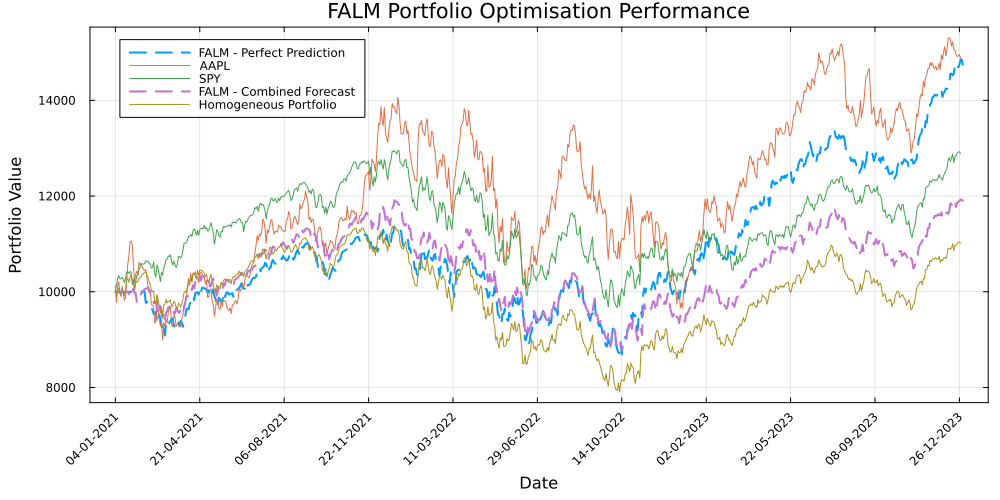

VaR: -0.015492150248860262
ES: -0.021626588958171034
Sharpe: 11.39689648893077
Max Drawdown: -0.23664621321405402
Annual Returns: 0.15289486114211415
Volatility: 0.009905754715923165


In [26]:
using Dates
using Statistics, DelimitedFiles

function get_VaR(data, alpha=0.05)
    returns = diff(data) ./ data[1:end-1]
    return quantile(returns, alpha)
end

function get_ES(data, alpha=0.05)
    returns = diff(data) ./ data[1:end-1]
    return mean(returns[returns .<= quantile(returns, alpha)])
end
function get_annual_returns(data)
    returns = diff(data) ./ data[1:end-1]
    return (1 + mean(returns))^252 - 1
end
function get_sharpe(data, riskFreeRate=0.04)
    return (get_annual_returns(data) - riskFreeRate) / std(diff(data) ./ data[1:end-1])
end
function get_max_drawdown(data)
    returns = diff(data) ./ data[1:end-1]
    cum_returns = cumprod(1 .+ returns)
    max_drawdown = 0
    for i in 1:length(cum_returns)
        for j in i:length(cum_returns)
            drawdown = (cum_returns[j] - cum_returns[i]) / cum_returns[i]
            if drawdown < max_drawdown
                max_drawdown = drawdown
            end
        end
    end
    return max_drawdown
end

initial_investment = 10^4
# aapl = in_data[in_data.symbol .== "AAPL", :close]
# aapl_returns = diff(aapl) ./ aapl[1:end-1]
# aapl_prices = cumprod(1 .+ aapl_returns) .* initial_investment
dates = results.date
ticks = Dates.format.(dates, "dd-mm-yyyy")
step_size = round(Int, length(results.dollarValue) / 10)
date_idx =1:step_size:length(ticks)

p = plot(results.dollarValue, label="FALM - Perfect Prediction", size=(1000, 500), title="FALM Portfolio Optimisation Performance", xlabel="Date", ylabel="Portfolio Value", leftmargin=5Plots.mm, bottommargin=10Plots.mm, 
legend=:topleft, grid=:on, frame=:box, xrotation=45, xticks=(1:step_size:length(results.dollarValue),ticks[end-length(results.dollarValue)+1:step_size:end]),
linestyle=:dash, linewidth=2)
homo_portfolio = nothing
best = nothing
for t in tickers
    # println(t)
    stock = in_data[in_data.symbol .== t, :close]
    stock_returns = diff(stock) ./ stock[1:end-1]
    stock_prices = cumprod(1 .+ stock_returns) .* initial_investment
    if isnothing(homo_portfolio)
        homo_portfolio = (stock_prices ./ length(tickers))
    else
        homo_portfolio = homo_portfolio .+ (stock_prices ./ length(tickers))
    end

    if isnothing(best)
        best = stock_returns
    else
        best = max.(best, stock_returns)
    end
    if t in ["AAPL", "SPY"]
        plot!(p, stock_prices, label=t)
    end
end

forecast_results = readdlm("falm_plots/FALM_Portfolio_Performance_combined.txt", '\t', Float64, '\n' )
plot!(p, forecast_results, label="FALM - Combined Forecast", linestyle=:dash, linewidth=2)
# println(forecast_results)
# println(best)
# best_plot = cumprod(1 .+ best) 
# plot!(p, best_plot, label="Theoretical Best")
plot!(p, homo_portfolio, label="Homogeneous Portfolio")
display(p)
savefig(p, "falm_plots/perfect/opt_params.svg")

println("VaR: ", get_VaR(results.dollarValue))
println("ES: ", get_ES(results.dollarValue))
println("Sharpe: ", get_sharpe(results.dollarValue))
println("Max Drawdown: ", get_max_drawdown(results.dollarValue))
println("Annual Returns: ", get_annual_returns(results.dollarValue))
println("Volatility: ", std(diff(results.dollarValue) ./ results.dollarValue[1:end-1]))
# jpm = in_data[in_data.symbol .== "JPM", :close]
# jpm_returns = diff(jpm) ./ jpm[1:end-1]
# jpm_prices = cumprod(1 .+ jpm_returns) .* initial_investment

# plot!(aapl_prices, label="AAPL")
# plot!(aapl_prices, label="AAPL")

# Optimising parameters

In [80]:
using Suppressor

in_data = stocks
assetIDs = unique(in_data.assetID)
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
tickers = ["AAPL", "MSFT", "ISRG", "BABA", "SPY", "EFA", "TLT", "GLD"]
stocks = get_interday_data(tickers, unix("2021-01-01"), unix("2024-01-01"))

my_logic!(context, data) = algo_trading_logic!(context, data)
feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)
function get_annual_returns(data)
    returns = diff(data) ./ data[1:end-1]
    return (1 + mean(returns))^252 - 1
end


function obj(x)
    evaluationEvents =[
        TimeEvent(t, "data_transfer") for t in sort(unique(in_data.date); rev=true)
    ]
    # println(x)
    my_init!(context) = algo_initialize!(context; lookahead=round(Int, x[2]), lpm_order=x[1], min_returns=x[4], min_allocation=x[3], httype=round(Int, x[5]), max_lookback=25, linear_lookback=0, tickers=tickers, transactionCost=0.02, initialCapital=10^4, assetIDs=assetIDs, currency="FEX/USD")
    my_context = run(
        in_data,
        my_init!,
        my_logic!,
        my_execute_orders!,
        expose_data;
        audit=true,
        verbose=false,
        initialEvents=evaluationEvents,
    )

    dollar_symbol = "FEX/USD"

    usdData = deepcopy(in_data[in_data.symbol .== my_context.extra.tickers[1], :])
    usdData[!, "assetID"] .= dollar_symbol
    usdData[!, "exchangeName"] .= "FEX"
    usdData[!, "symbol"] .= "USD"
    usdData[!, [:close, :high, :low, :open]] .= 1.0
    usdData[!, [:volume]] .= 0
    OHLCV_data = vcat(in_data, usdData)

    results = @suppress summarizePerformance(OHLCV_data, my_context; includeAccounts=false, riskFreeRate=0.04)
    return -get_annual_returns(results.dollarValue)
end
# 
init_points = [[1.0, 1.0, 0.7, 0.00015, 1.0], [2.0, 2.0, 0.5, 0.00025, 2.0], [3.0, 2.0, 1.0, 0.00045, 1.0], [4.0, 3.0, 0.00, 0.00000, 2.0], [3.0, 5.0, 0.80, 0.00000, 1.0]]
granularity = [0.1, 1.0, 0.01, 0.00001, 1.0]
geq(x) = all(x .>= 0)
# lpm_constraints(x) = (x[1] <= 4.0)
lookahead_constraints(x) = (x[2] >= 1.0)
min_allocation_constraints(x) =  (x[3] <= 1.0)
ht_type(x) = (x[5] == 1.0) || (x[5] == 2.0)


for params in init_points
    returns_problem = DSProblem(5, objective=obj, granularity=granularity, poll=OrthoMADS())
    # AddProgressiveConstraint(returns_problem, lpm_constraints)
    AddExtremeConstraint(returns_problem, lookahead_constraints)
    AddExtremeConstraint(returns_problem, geq)
    AddExtremeConstraint(returns_problem, min_allocation_constraints)
    AddExtremeConstraint(returns_problem, ht_type)
    SetInitialPoint(returns_problem, params)
    Optimize!(returns_problem)
end


MADS Run Summary
--------------------------------------------------------
Feasible Solution           [0.9, 1.0, 0.7, 0.0002, 2.0]
Feasible Cost               -0.12966485302217534
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  54
Function Evaluations        42
Cache hits                  309
Optimization Status         Mesh Precision limit

Runtime                     1034.8374741077423
Search Time                 6.68e-6
Poll Time                   0.013850039000000003
Blackbox Evaluation Time    1007.352015746999
MADS Run Summary
---------------------------------------------------------
Feasible Solution           [0.6, 1.0, 0.56, 0.0002, 2.0]
Feasible Cost               -0.1506642815139838
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  68
Function Evaluations        118
Cache hits                  343
Optimization Status         Mesh Precision limit

Runtime                   